Preprocessing

In [ ]:
import pandas as pd
df = pd.read_csv('reviews.csv')

In [ ]:
df.head()

,Score,Text,Clean_Text,label
0,5,I have bought several of the Vitality canned d...,bought sever vital dog food product found good...,1
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...,0
2,4,This is a confection that has been around a fe...,thi confect ha around centuri light pillowi ci...,1
3,2,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...,0
4,5,Great taffy at a great price. There was a wid...,great taffi great price wa wide assort yummi t...,1


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
import re
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def review_to_words(raw_review):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    words = word_tokenize(letters_only.lower())
    my_stemmer = PorterStemmer()
    stemmed_words = [my_stemmer.stem(word) for word in words]
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in stemmed_words if not w in stops]
    # return(" ".join(meaningful_words))
    return meaningful_words

Tokenization

In [ ]:
df['tokenized'] = df['Text'].apply(review_to_words)

In [ ]:
df.head()

,Score,Text,Clean_Text,label,tokenized
0,5,I have bought several of the Vitality canned d...,bought sever vital dog food product found good...,1,"[bought, sever, vital, dog, food, product, fou..."
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...,0,"[product, arriv, label, jumbo, salt, peanut, p..."
2,4,This is a confection that has been around a fe...,thi confect ha around centuri light pillowi ci...,1,"[thi, confect, ha, around, centuri, light, pil..."
3,2,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...,0,"[look, secret, ingredi, robitussin, believ, fo..."
4,5,Great taffy at a great price. There was a wid...,great taffi great price wa wide assort yummi t...,1,"[great, taffi, great, price, wa, wide, assort,..."


In [ ]:
df = df.drop(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 
              'HelpfulnessDenominator', 'Summary', 'Time', 'ProfileName'], axis=1)

In [ ]:
df['label'] = None

In [ ]:
df.shape

(568454, 5)

In [ ]:
for i in df.index:
    if df.Score[i] == 1 or df.Score[i] == 2:
        df.loc[i, 'label'] = 0
    elif df.Score[i] == 3 or df.Score[i] == 4 or df.Score[i] == 5 :
        df.loc[i, 'label'] = 1

In [ ]:
X_tokenized = df['tokenized'].values
y = df['label'].values

In [ ]:
vocab = {}

for sentence in X_tokenized:
  for word in sentence:
    if word not in vocab:
      vocab[word] = len(vocab)

In [ ]:
len(vocab)

80011

In [ ]:
X_indexed = [[vocab[word] for word in sentence] for sentence in X_tokenized]

Outlier

In [ ]:
index = None
for i, x in enumerate(X_indexed):
    if len(x) == 0:
        index = i
        break

if index is not None:
    print(f"The index of the element with length 0 is {index}.")
else:
    print("No element with length 0 was found.")


No element with length 0 was found.


Bucketing

In [ ]:
from collections import defaultdict

bucketed_X = defaultdict(list)
for i, x in enumerate(X_indexed):
    bucketed_X[len(x)].append(i)

Batching

In [ ]:
batch_indices = []

for _, sequence_indices in bucketed_X.items():
    batch_indices.extend([sequence_indices[i:i+32] for i in range(0, len(sequence_indices), 32)])

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

X_batched = []

for batch in batch_indices:
    sequences = [X_indexed[i] for i in batch]
    padded = pad_sequence([torch.LongTensor(x) for x in sequences], batch_first=True)
    X_batched.append(padded)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
dataset = TextDataset(X_batched, torch.tensor(y))
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

LSTM

In [ ]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        logits = self.fc(hidden[-1])
        return torch.sigmoid(logits)

In [ ]:
model = LSTMModel(len(vocab), 100, 50, 2)

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Training using 1000 data samples

In [ ]:
import numpy as np
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dt = 0
t0 = 0
train_losses = np.zeros(10)
train_accs = np.zeros(10)

for epoch in range(10):
    t0 = datetime.now()
    train_loss = []
    train_acc = []
    model.train()
    for X_batch, y_batch in dataloader:

        X_batch = X_batch.to(device)
        X_batch = X_batch.flatten()
        y_batch = y_batch.float().to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)  #squeeze()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        # print('train loss', loss.item())
        train_acc.append(((output.squeeze()>0.5).float() == y_batch.squeeze()).float().mean().item())  # add squeeze() here
        # print('train acc', (output.squeeze()>0.5).float() == y_batch.squeeze())
        # dt = datetime.now() - t0
        # print('dt', dt)
    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    train_acc = np.mean(train_acc)
    train_accs[epoch] =train_acc
    dt = datetime.now() - t0
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, duration: {dt}")

Epoch 1, Train Loss: 0.2559, Train Acc: 0.9051, duration: 0:01:35.319899
Epoch 2, Train Loss: 0.1893, Train Acc: 0.9282, duration: 0:01:42.127701
Epoch 3, Train Loss: 0.0824, Train Acc: 0.9667, duration: 0:01:34.753130
Epoch 4, Train Loss: 0.0297, Train Acc: 0.9872, duration: 0:01:39.759399
Epoch 5, Train Loss: 0.0148, Train Acc: 0.9949, duration: 0:01:37.326059
Epoch 6, Train Loss: 0.0068, Train Acc: 0.9974, duration: 0:01:35.432388
Epoch 7, Train Loss: 0.0064, Train Acc: 0.9949, duration: 0:01:37.659487
Epoch 8, Train Loss: 0.0053, Train Acc: 0.9974, duration: 0:01:37.172830
Epoch 9, Train Loss: 0.0049, Train Acc: 0.9974, duration: 0:01:36.697759
Epoch 10, Train Loss: 0.0047, Train Acc: 0.9974, duration: 0:01:51.815861


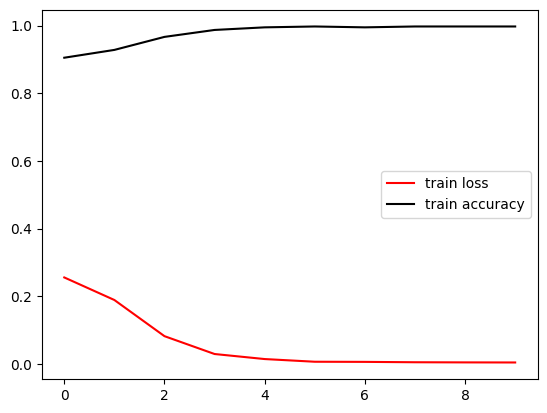

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train loss', color = 'red')
plt.plot(train_accs, label = 'train accuracy', color = 'black')
plt.legend()
plt.show();

In [ ]:
dataset = TextDataset(X_batched, torch.tensor(y))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def batch_gd(model, criterion, optimizer, train_dataloader, test_dataloader, epoch):
  train_losses = np.zeros(epoch)
  test_losses = np.zeros(epoch)

  for it in range(epoch):
    t0 = datetime.now()

    train_loss = []
    for X_batch, y_batch in train_dataloader:
      X_batch = X_batch.to(device)
      X_batch = X_batch.flatten()
      y_batch = y_batch.float().to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    test_loss = []

    for X_batch, y_batch in test_dataloader:
      X_batch = X_batch.to(device)
      X_batch = X_batch.flatten()
      y_batch = y_batch.float().to(device)

      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it + 1} / {epoch}, Train loss: {train_loss:.4f},\
     Test loss: {test_loss:.4f}, Duration: {dt}')
  return train_losses, test_losses

Training using the whole dataset

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epoch = 25)

Epoch 1 / 25, Train loss: 0.4235,     Test loss: 0.4311, Duration: 0:02:45.330751
Epoch 2 / 25, Train loss: 0.4171,     Test loss: 0.4430, Duration: 0:02:44.453604
Epoch 3 / 25, Train loss: 0.4119,     Test loss: 0.4506, Duration: 0:02:45.401951
Epoch 4 / 25, Train loss: 0.4102,     Test loss: 0.4383, Duration: 0:02:45.024131
Epoch 5 / 25, Train loss: 0.4094,     Test loss: 0.4465, Duration: 0:02:44.773740
Epoch 6 / 25, Train loss: 0.4054,     Test loss: 0.4426, Duration: 0:02:44.685703
Epoch 7 / 25, Train loss: 0.4033,     Test loss: 0.4668, Duration: 0:02:45.433844
Epoch 8 / 25, Train loss: 0.4033,     Test loss: 0.4758, Duration: 0:02:44.441817
Epoch 9 / 25, Train loss: 0.4059,     Test loss: 0.4569, Duration: 0:02:44.570650
Epoch 10 / 25, Train loss: 0.4025,     Test loss: 0.4541, Duration: 0:02:44.244223
Epoch 11 / 25, Train loss: 0.3972,     Test loss: 0.5297, Duration: 0:02:45.469799
Epoch 12 / 25, Train loss: 0.3974,     Test loss: 0.4459, Duration: 0:02:56.843669
Epoch 13 / 25

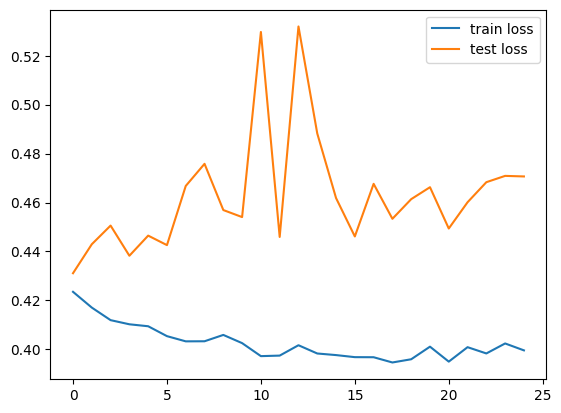

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show();

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_dataloader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.flatten()

  outputs = model(inputs)
  if outputs >= 0.5:
    outputs = 1
  else:
    outputs = 0

  # _, predictions = torch.max(outputs, 1)

  n_correct += (outputs == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, outputs in test_dataloader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.flatten()
  outputs = model(inputs)
  if outputs >= 0.5:
    outputs = 1
  else:
    outputs = 0
  # _, predictions = torch.max(outputs, 1)

  n_correct += (outputs == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'train accuracy: {train_acc:.4f} \n test accuracy: {test_acc:.4f}')

train accuracy: 0.8655 
 test accuracy: 0.9629
